# CLIP Visual Feature Inspection

Run a ViT-based CLIP model on a reference image, capture intermediate feature maps and attention weights, and export them as images for offline analysis. Generated figures are saved under `notebooks/clip_feature_maps`.

In [1]:
%matplotlib inline
import math
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

import clip
from clip.model import VisionTransformer
from torch.nn import functional as F


/home/lji/miniconda3/envs/CLIP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Resolve repo-relative paths and prepare output/cache folders
repo_root = Path.cwd()
if not (repo_root / '.git').exists():
    for parent in repo_root.resolve().parents:
        if (parent / '.git').exists():
            repo_root = parent
            break

assets_dir = repo_root / 'notebooks' / 'clip_feature_maps'
assets_dir.mkdir(parents=True, exist_ok=True)
cache_dir = repo_root / 'data' / 'clip_cache'
cache_dir.mkdir(parents=True, exist_ok=True)

model_name = 'ViT-B/32'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

try:
    model, preprocess = clip.load(model_name, device=device, download_root=str(cache_dir))
except Exception as exc:
    raise RuntimeError('Failed to load CLIP weights. Download the checkpoint manually into "{}".'.format(cache_dir)) from exc

if not isinstance(model.visual, VisionTransformer):
    raise ValueError(f'This notebook expects a ViT-based checkpoint. Got {type(model.visual)} instead.')

model.eval();
patch_grid_size = int(model.visual.input_resolution / model.visual.conv1.kernel_size[0])

print(f'Using {model_name} on {device}')
print(f'Feature map exports will be written to: {assets_dir}')


Using ViT-B/32 on cuda
Feature map exports will be written to: /home/lji/VLM/CLIP/notebooks/clip_feature_maps


In [3]:
# Hook helpers for capturing feature maps and attention weights

def register_vit_hooks(visual_module):
    feature_store = {}
    attention_store = {}
    hooks = []

    def store_patch_embedding(module, inputs, output):
        feature_store['patch_embedding'] = output.detach().cpu()

    hooks.append(visual_module.conv1.register_forward_hook(store_patch_embedding))

    def make_block_hook(index):
        def hook(module, inputs, output):
            feature_store[f'block_{index:02d}_hidden'] = output.detach().cpu()
        return hook

    def make_attention_hook(index):
        def hook(module, inputs, output):
            query, key, value = inputs[:3]
            key_padding_mask = inputs[3] if len(inputs) > 3 else None
            attn_mask = inputs[5] if len(inputs) > 5 else None
            with torch.no_grad():
                _, attn_weights = F.multi_head_attention_forward(
                    query, key, value,
                    embed_dim_to_check=module.embed_dim,
                    num_heads=module.num_heads,
                    in_proj_weight=module.in_proj_weight,
                    in_proj_bias=module.in_proj_bias,
                    bias_k=module.bias_k,
                    bias_v=module.bias_v,
                    add_zero_attn=module.add_zero_attn,
                    dropout_p=module.dropout,
                    out_proj_weight=module.out_proj.weight,
                    out_proj_bias=module.out_proj.bias,
                    training=module.training,
                    key_padding_mask=key_padding_mask,
                    need_weights=True,
                    attn_mask=attn_mask,
                    use_separate_proj_weight=not getattr(module, '_qkv_same_embed_dim', True),
                    q_proj_weight=module.q_proj_weight if not getattr(module, '_qkv_same_embed_dim', True) else None,
                    k_proj_weight=module.k_proj_weight if not getattr(module, '_qkv_same_embed_dim', True) else None,
                    v_proj_weight=module.v_proj_weight if not getattr(module, '_qkv_same_embed_dim', True) else None,
                    average_attn_weights=False,
                )
            attention_store[f'block_{index:02d}_attn'] = attn_weights.detach().cpu()
        return hook

    for idx, block in enumerate(visual_module.transformer.resblocks):
        hooks.append(block.register_forward_hook(make_block_hook(idx)))
        hooks.append(block.attn.register_forward_hook(make_attention_hook(idx)))

    return hooks, feature_store, attention_store


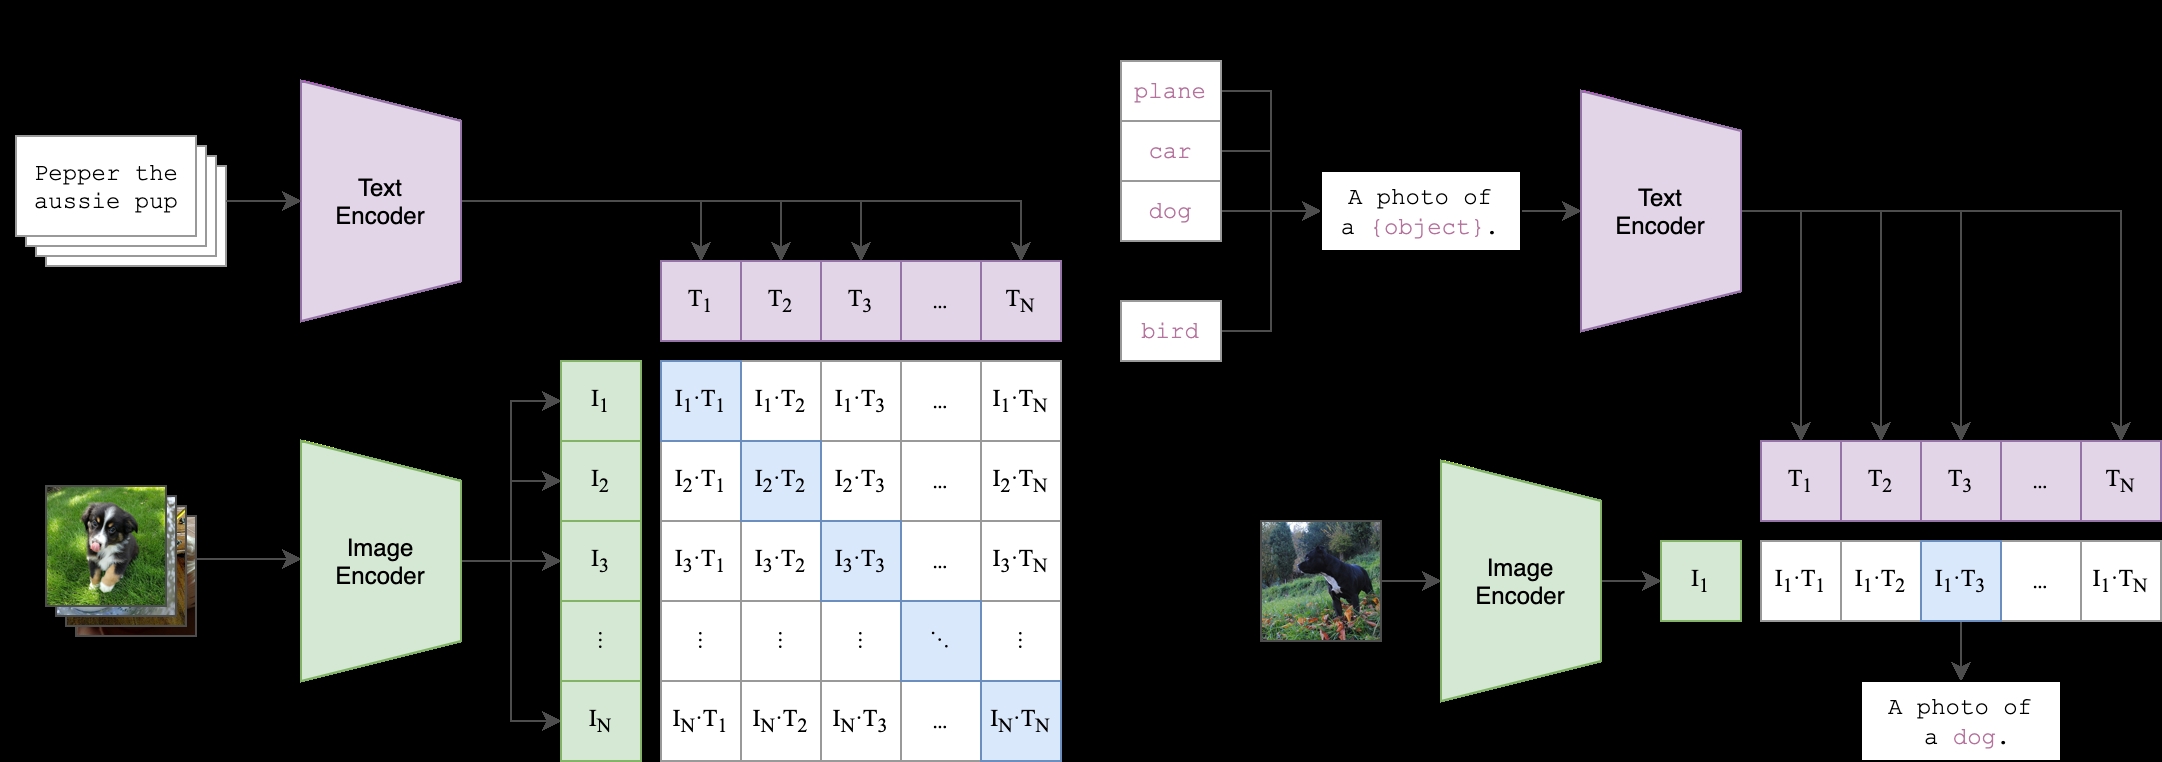

Zero-shot label probabilities:
   a diagram: 0.993
       a dog: 0.005
       a cat: 0.002
Captured 12 transformer block activations


In [4]:
# Run a forward pass on the reference image to populate the caches
image_path = repo_root / 'CLIP.png'
if not image_path.exists():
    raise FileNotFoundError('Expected reference image at {}'.format(image_path))

reference_image = Image.open(image_path).convert('RGB')
display(reference_image)
reference_image_np = np.array(reference_image)

hooks, feature_cache, attention_cache = register_vit_hooks(model.visual)

image_tensor = preprocess(reference_image).unsqueeze(0).to(device)
text_tensor = clip.tokenize(['a diagram', 'a dog', 'a cat']).to(device)

with torch.no_grad():
    logits_per_image, _ = model(image_tensor, text_tensor)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy().squeeze()

for hook in hooks:
    hook.remove()

print('Zero-shot label probabilities:')
for label, score in zip(['a diagram', 'a dog', 'a cat'], probs):
    print(f'  {label:>10s}: {score:.3f}')

print(f'Captured {len([k for k in feature_cache if k.startswith("block")])} transformer block activations')


In [5]:
# Visualization helpers

def _ensure_axes_grid(axes, rows, cols):
    return np.array(axes).reshape(rows, cols)

def _resize_map_to_image(arr2d, target_hw):
    tensor = torch.from_numpy(arr2d).float().unsqueeze(0).unsqueeze(0)
    upsampled = F.interpolate(tensor, size=target_hw, mode='bilinear', align_corners=False)
    return upsampled.squeeze().numpy()

def _normalize(arr):
    arr = arr - arr.min()
    denom = arr.max() if arr.max() > 0 else 1.0
    return arr / (denom + 1e-6)

def _save_overlay(base_image, heatmap, output_path, title=None, cmap='plasma', alpha=0.45):
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.imshow(base_image)
    ax.imshow(heatmap, cmap=cmap, alpha=alpha)
    if title:
        ax.set_title(title)
    ax.axis('off')
    fig.savefig(output_path, dpi=200, bbox_inches='tight')
    plt.close(fig)
    return output_path

def save_patch_embedding_grid(patch_tensor, base_image, max_channels=16):
    grid = patch_tensor.squeeze(0).to(torch.float32)
    channels = min(max_channels, grid.shape[0])
    rows = math.ceil(channels / 4)
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = _ensure_axes_grid(axes, rows, cols)
    for idx, ax in enumerate(axes.flat):
        if idx < channels:
            fmap = grid[idx].cpu().numpy()
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-6)
            ax.imshow(fmap, cmap='magma')
        ax.axis('off')
    fig.suptitle('Patch embedding channels (first {})'.format(channels))
    fig.tight_layout()
    grid_path = assets_dir / 'patch_embedding_channels.png'
    fig.savefig(grid_path, dpi=200)
    plt.close(fig)

    activation_map = grid.pow(2).sum(dim=0).sqrt().cpu().numpy()
    overlay_map = _normalize(_resize_map_to_image(activation_map, base_image.shape[:2]))
    overlay_path = assets_dir / 'patch_embedding_overlay.png'
    _save_overlay(base_image, overlay_map, overlay_path, title='Patch embedding activation', cmap='magma')
    return {'grid': grid_path, 'overlay': overlay_path}

def save_block_token_maps(feature_cache, grid_size, base_image):
    artifacts = []
    target_hw = base_image.shape[:2]
    for key in sorted(feature_cache):
        if 'block_' not in key:
            continue
        data = feature_cache[key].permute(1, 0, 2)[0].to(torch.float32)
        patch_tokens = data[1:]
        token_norms = patch_tokens.norm(dim=-1).reshape(grid_size, grid_size).cpu().numpy()

        fig, ax = plt.subplots(figsize=(4.5, 4.5))
        im = ax.imshow(token_norms, cmap='viridis')
        ax.set_title(f'{key} | token norms')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        heatmap_path = assets_dir / f'{key}_token_norms.png'
        fig.savefig(heatmap_path, dpi=200, bbox_inches='tight')
        plt.close(fig)

        overlay_map = _normalize(_resize_map_to_image(token_norms, target_hw))
        overlay_path = assets_dir / f'{key}_token_overlay.png'
        _save_overlay(base_image, overlay_map, overlay_path, title=f'{key} | token overlay', cmap='viridis')

        artifacts.append({'layer': key, 'heatmap': heatmap_path, 'overlay': overlay_path})
    return artifacts

def save_attention_maps(attention_cache, grid_size, base_image):
    artifacts = []
    target_hw = base_image.shape[:2]
    for key in sorted(attention_cache):
        attn = attention_cache[key][0].to(torch.float32)
        heads = attn.shape[0]
        cls_attn = attn[:, 0, 1:].reshape(heads, grid_size, grid_size).cpu().numpy()

        rows = math.ceil(heads / 4)
        cols = 4
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        axes = _ensure_axes_grid(axes, rows, cols)
        for idx, ax in enumerate(axes.flat):
            if idx < heads:
                ax.imshow(cls_attn[idx], cmap='plasma')
                ax.set_title(f'Head {idx}')
            ax.axis('off')
        fig.suptitle(f'{key} | CLS attention heads')
        fig.tight_layout()
        heads_path = assets_dir / f'{key}_cls_attention_heads.png'
        fig.savefig(heads_path, dpi=200)
        plt.close(fig)

        mean_map = cls_attn.mean(axis=0)
        fig, ax = plt.subplots(figsize=(4.5, 4.5))
        im = ax.imshow(mean_map, cmap='plasma')
        ax.set_title(f'{key} | CLS attention mean')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        mean_heatmap_path = assets_dir / f'{key}_cls_attention_mean.png'
        fig.savefig(mean_heatmap_path, dpi=200, bbox_inches='tight')
        plt.close(fig)

        mean_overlay_map = _normalize(_resize_map_to_image(mean_map, target_hw))
        mean_overlay_path = assets_dir / f'{key}_cls_attention_overlay.png'
        _save_overlay(base_image, mean_overlay_map, mean_overlay_path, title=f'{key} | attention overlay', cmap='plasma')

        artifacts.append({'layer': key, 'heads_grid': heads_path, 'mean_heatmap': mean_heatmap_path, 'mean_overlay': mean_overlay_path})
    return artifacts


In [6]:
# Generate and persist all figures
patch_artifacts = save_patch_embedding_grid(feature_cache['patch_embedding'], reference_image_np)
print(f"Saved patch embedding channel grid -> {patch_artifacts['grid']}")
print(f"Saved patch embedding overlay -> {patch_artifacts['overlay']}")

token_artifacts = save_block_token_maps(feature_cache, patch_grid_size, reference_image_np)
print(f'Saved token activation artifacts for {len(token_artifacts)} transformer blocks')

attention_artifacts = save_attention_maps(attention_cache, patch_grid_size, reference_image_np)
print(f'Saved attention artifacts for {len(attention_artifacts)} transformer blocks')


RuntimeError: "sqrt_vml_cpu" not implemented for 'Half'

In [ ]:
# Quick file manifest for convenience
for artifact in token_artifacts:
    print(artifact['heatmap'])
    print(artifact['overlay'])
for artifact in attention_artifacts:
    print(artifact['heads_grid'])
    print(artifact['mean_heatmap'])
    print(artifact['mean_overlay'])
print(patch_artifacts['grid'])
print(patch_artifacts['overlay'])
